# Préparez des données pour un organisme de santé publique

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

## Étape 1 : Nettoyez et filtrez des features et produits 

Je met le chargement du csv en commentaire pour éviter de le recharger à chaque fois que je lance le code. Si vous voyez ceci c'est que j'ai oublié de l'enlever.

In [3]:
# df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

# df_backup = df
# df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df_backup

Commençons par analyser un petit peu les données.

In [5]:
df.shape

(320772, 162)

In [6]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

Nous allons séléctioner une variable ayant entre 50% et 80% de valeurs manquantes. Ce sera notre variable à analyser.

In [7]:
missing_values = df.isnull().mean()

missing_values.loc[missing_values > 0.5].loc[missing_values < 0.8].sort_values()

additives_tags      0.517788
additives_fr        0.517788
cholesterol_100g    0.550802
trans-fat_100g      0.553271
calcium_100g        0.560280
vitamin-c_100g      0.560850
iron_100g           0.562113
vitamin-a_100g      0.571178
quantity            0.673229
pnns_groups_2       0.705426
pnns_groups_1       0.714710
categories_fr       0.736850
categories          0.736854
categories_tags     0.736919
main_category_fr    0.736991
main_category       0.736991
packaging_tags      0.753841
packaging           0.753844
image_url           0.763583
image_small_url     0.763583
dtype: float64

La variable "main_category" paraît parfaite. C'est une variable catégorielle et elle est ni trop vide ni trop remplis.

In [8]:
target = df["main_category"]

Maintenant, visualisons les données en fonctions du pourcentage de valuers manquantes.

Text(0.5, 1.0, 'Pourcentage de valeurs manquantes pour chaque variable')

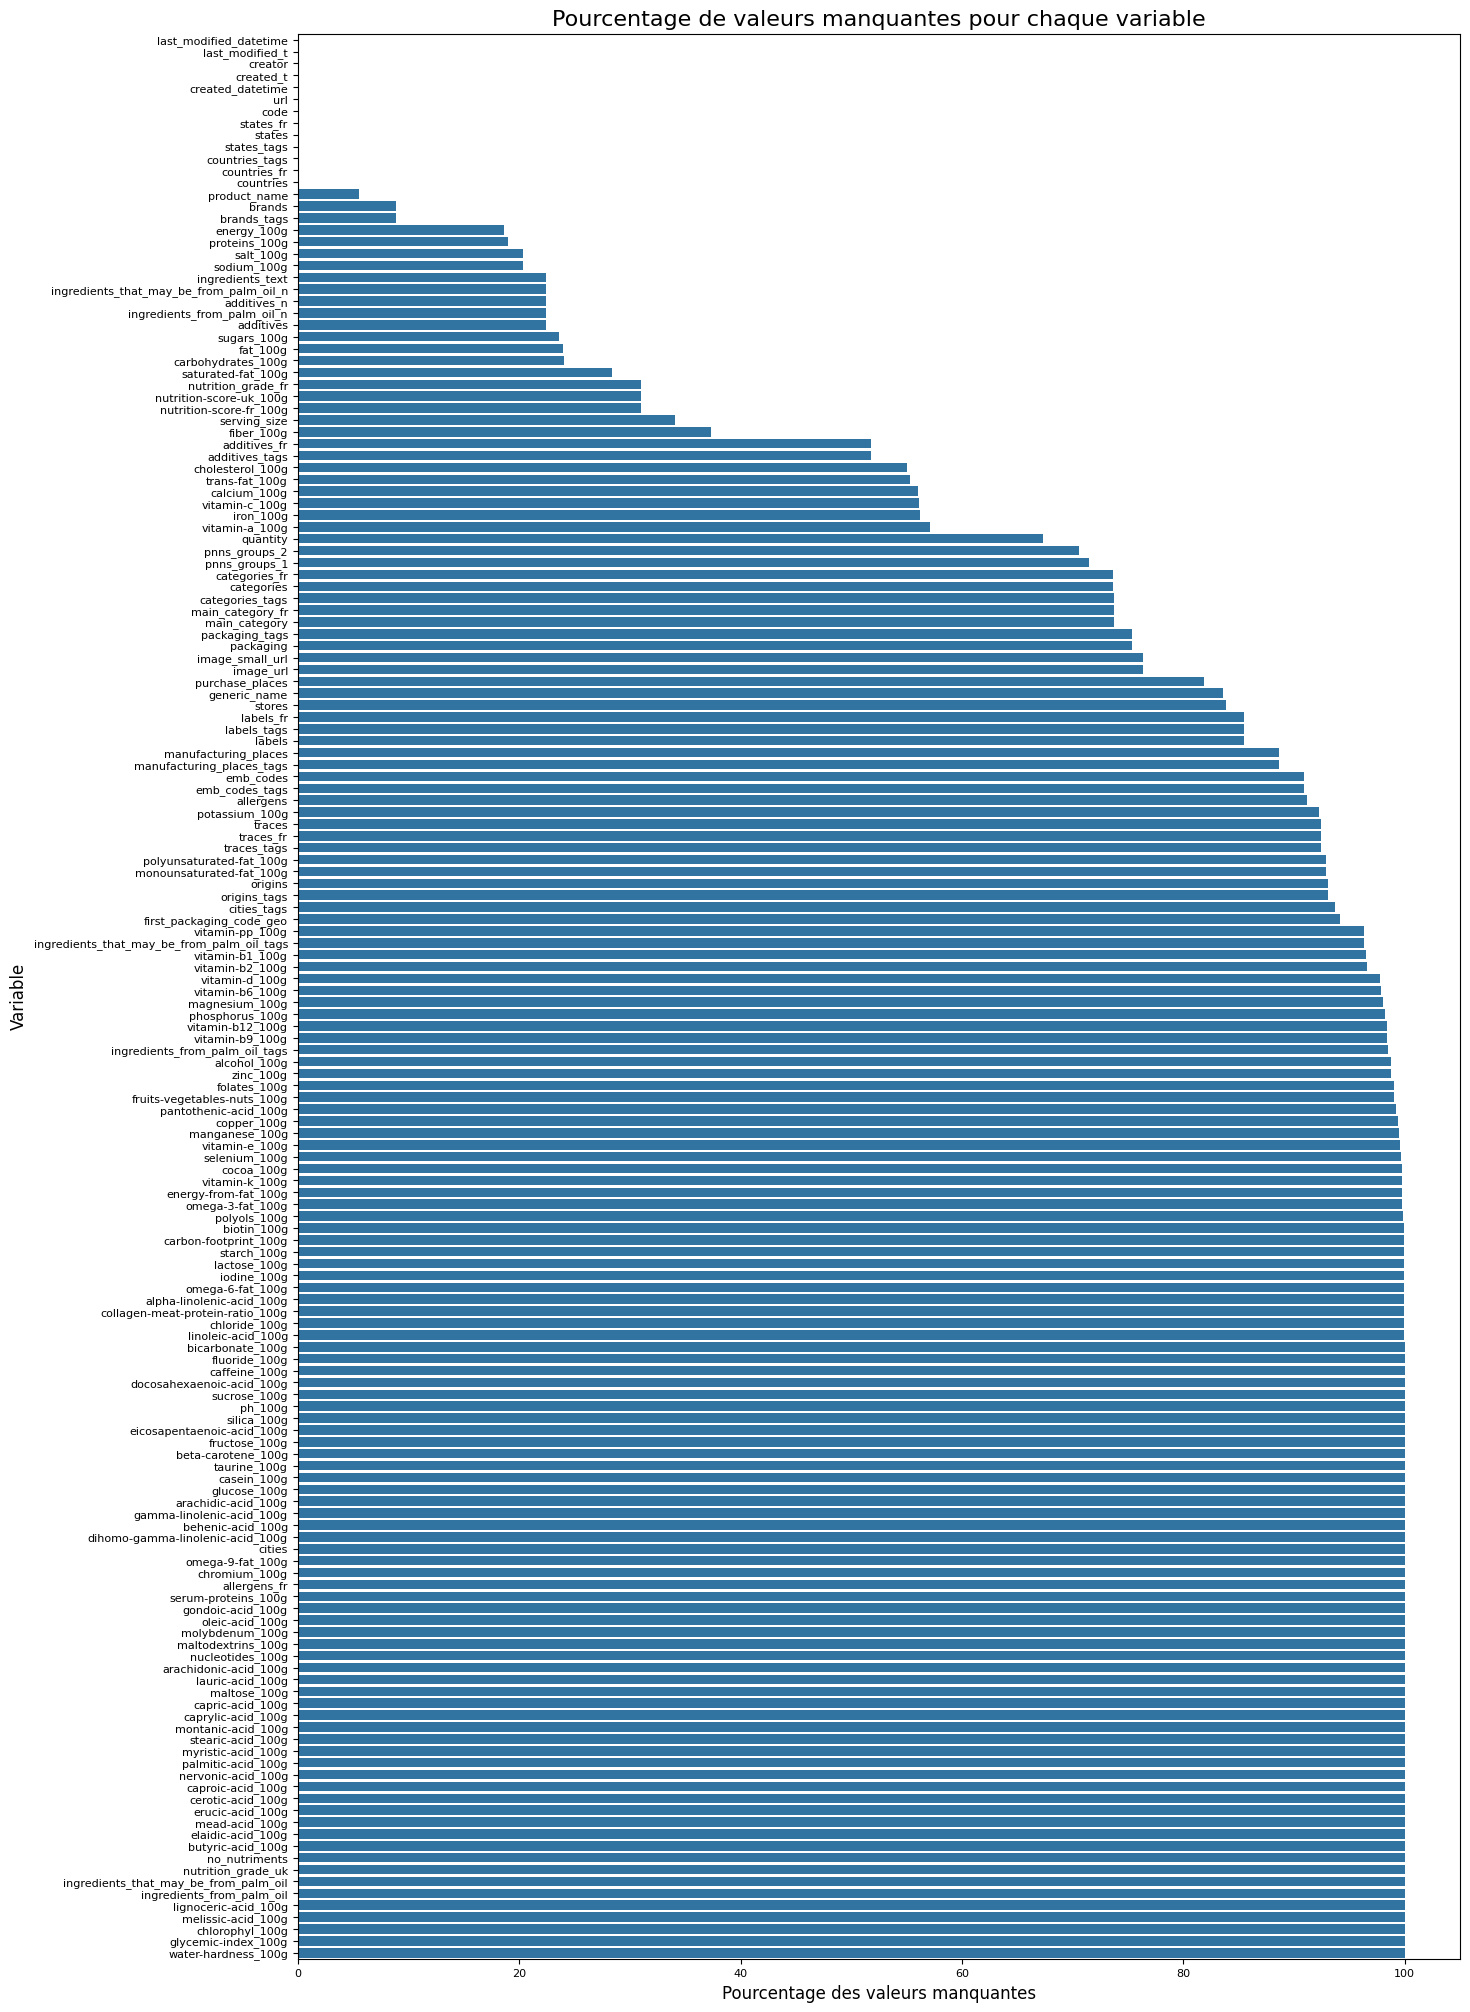

In [9]:
proportion_of_emptiness = df.isnull().mean() * 100
proportion_of_emptiness = pd.DataFrame(proportion_of_emptiness).reset_index().sort_values(0)

fig = plt.figure(figsize=(15, 25))

plt.rcParams.update({"font.size": 8})
sns.barplot(data=proportion_of_emptiness, x=0, y="index")
plt.xlabel("Pourcentage des valeurs manquantes", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=16)

Supprimons les variables comportants moins de 50% de taux de remplissage.

In [10]:
df = df.loc[:, missing_values < 0.5]

Utilisons l'URL des produits pour supprimer les doublons.

In [11]:
duplicated_rows = df["url"].duplicated()
duplicated_rows.sum()

np.int64(22)

In [12]:
df = df.loc[duplicated_rows == False]
df.duplicated().sum()

np.int64(0)

Nous allons maintenant faire la sélection des variables qui seront destinées à prédire la variable cible. Pour cela, nous choisissons des variables étant remplies au minimum à 50%. Il faut, bien sûr, aussi qu'elles aient un rapport avec notre variable cible afin qu'elles puissent la prédire.

In [13]:
df = df[[
    "brands",
    "ingredients_text",
    "nutrition_grade_fr",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g"
]]

In [14]:
def features_selection(dataframe):
    dataframe.columns
    target = dataframe["main_category"]
    df.isnull().mean()
    dataframe = dataframe.loc[df["code"].duplicated() == False]
    dataframe = dataframe[[
        "brands",
        "ingredients_text",
        "nutrition_grade_fr",
        "energy_100g",
        "fat_100g",
        "sugars_100g",
        "fiber_100g",
        "proteins_100g",
        "salt_100g"
    ]]
    return (dataframe, target)

## Étape 2 : Identifiez et traitez les valeurs aberrantes

Occupons-nous maintenant de traiter les valeurs aberrantes. Pour cela, nous allons en premier lieu utiliser des boîtes à moustaches afin de visualiser la distribution des valeurs nutritives.

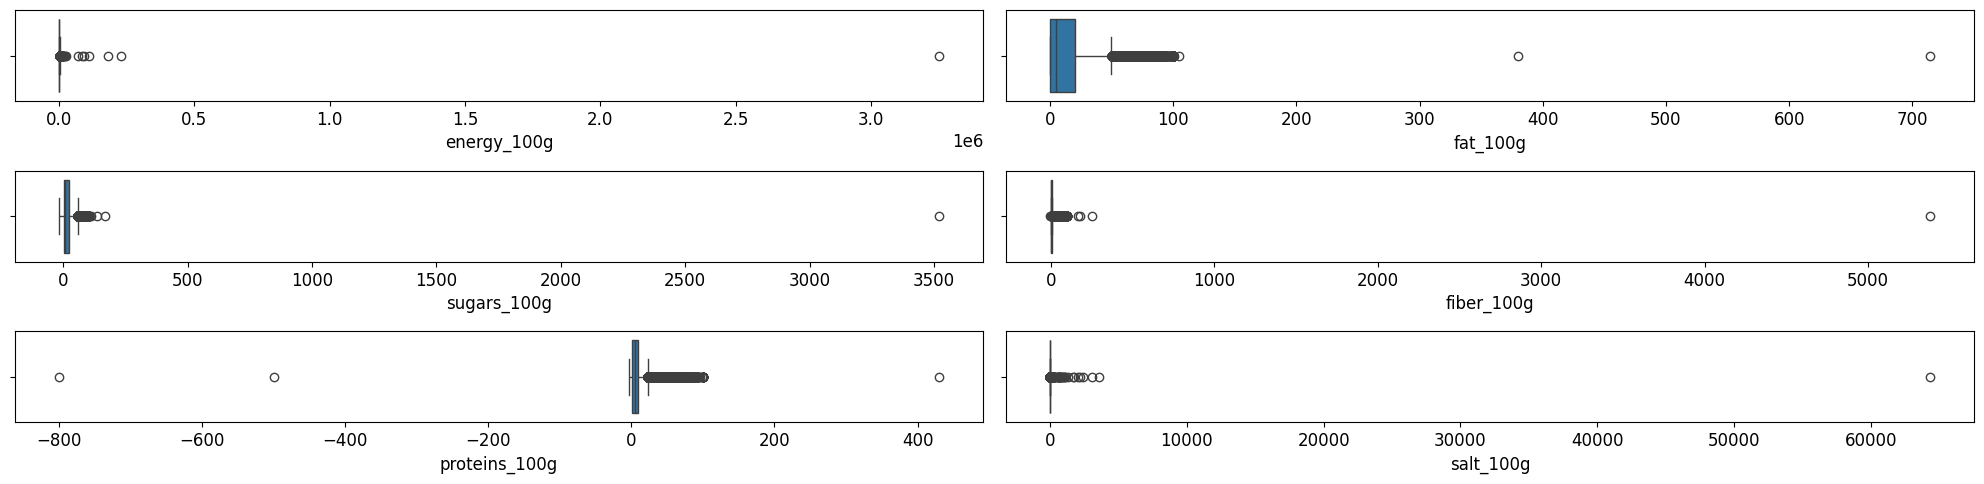

In [15]:
nutritive_values = ["energy_100g", "fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()
for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()

On repère deux problèmes. Premièrement, certaines valeurs sont négatives, ce qui, vous en conviendrez, est impossible. Deuxièmement, des valeurs dépassent la valeur maximum possible pour ce type de données. Par exemple, le produit le plus gras contient plus de 700g de gras pour 100g de produit. C'est bien évidemment impossible. Nous allons donc supprimer les valeurs en trop, et nous allons même rechercher les aliments contenant le plus de protéines et de fibres possible, ainsi que l'aliment apportant le plus de kilos joules au corps, afin d'estimer des valeurs maximum plus précises pour ces données.

In [16]:
df = df.loc[df["energy_100g"] >= 0].loc[df["energy_100g"] < 3700]
df = df.loc[df["fat_100g"] >= 0].loc[df["fat_100g"] < 100]
df = df.loc[df["sugars_100g"] >= 0].loc[df["sugars_100g"] < 100]
df = df.loc[df["fiber_100g"] >= 0].loc[df["fiber_100g"] < 16]
df = df.loc[df["proteins_100g"] >= 0].loc[df["proteins_100g"] < 58]
df = df.loc[df["salt_100g"] >= 0].loc[df["salt_100g"] < 100]

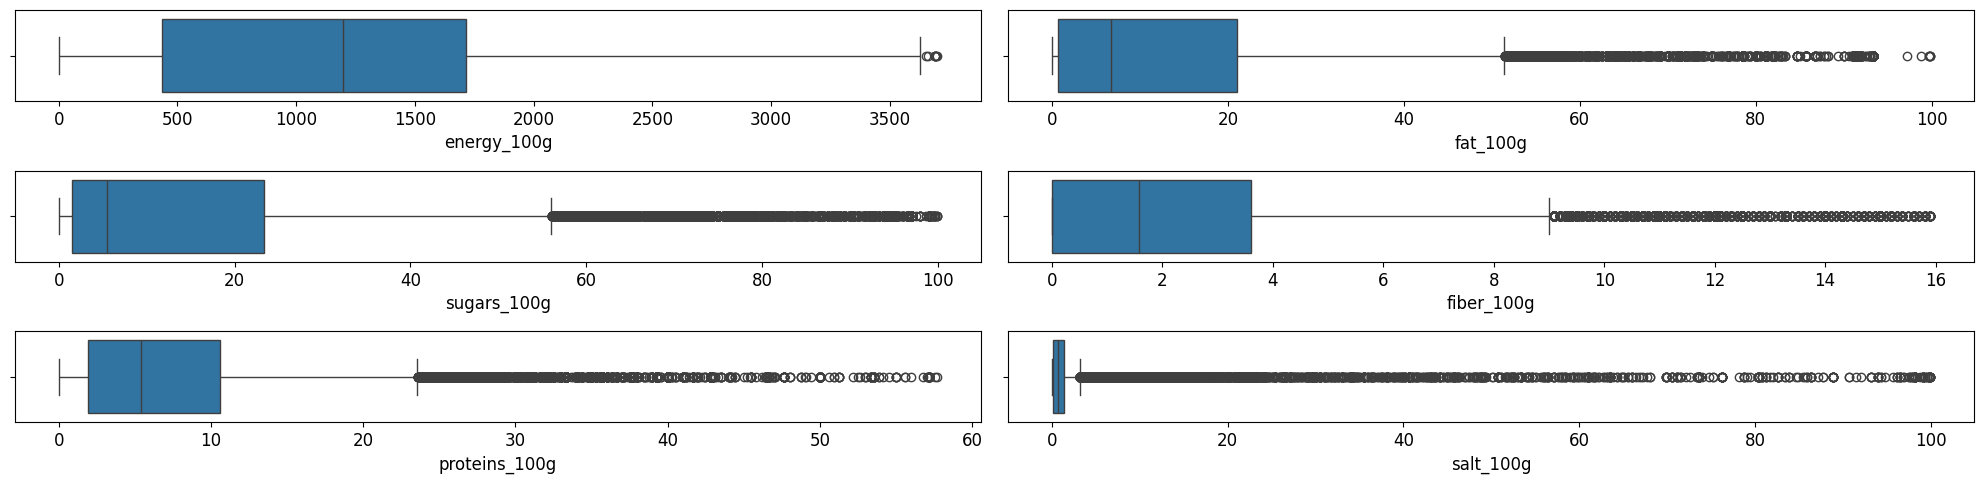

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])
plt.tight_layout()

Maintenant que nous nous sommes débarrassés des valeurs explicitement aberrantes, nous allons utiliser des méthodes statistiques pour en détecter davantage.

In [18]:
iqr_scores = []

for value in nutritive_values:
    iqr = np.quantile(df[value], q=[0.25, 0.75])
    iqr_scores.append((iqr[1] + 1.5*(iqr[1] - iqr[0])))

iqr_scores_df = pd.DataFrame(iqr_scores)
iqr_scores_df.index = nutritive_values
iqr_scores_df.rename(columns={0:"IQR scores"}, inplace=True)
iqr_scores_df

,IQR scores
energy_100g,3636.50000
fat_100g,51.45000
sugars_100g,56.01500
fiber_100g,9.00000
proteins_100g,23.56500
salt_100g,3.21955


Maintenant, nous allons supprimer les produits dont les valeurs dépassent le score interquartile.

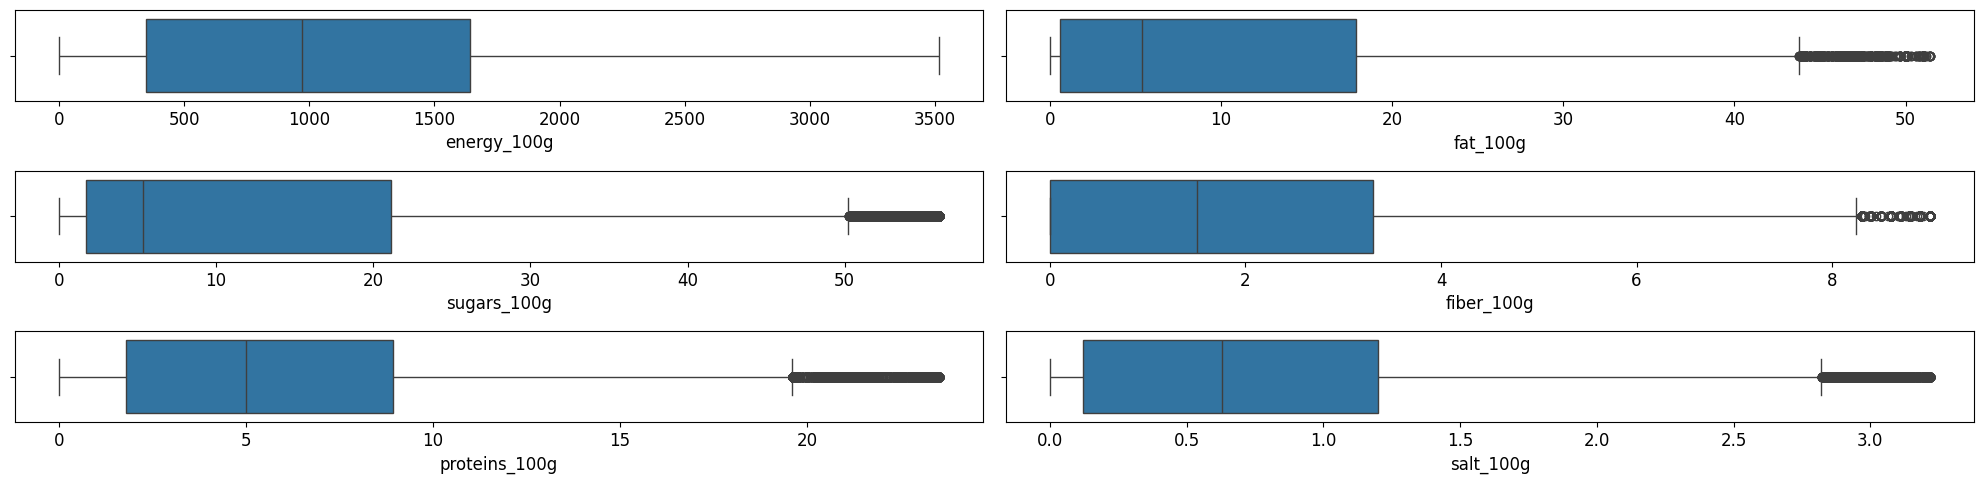

In [19]:
for value in iqr_scores_df.index:
    df = df.loc[df[value] <= iqr_scores_df.loc[value, "IQR scores"]]


fig, ax = plt.subplots(3, 2, figsize=(20,5))
ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])
plt.tight_layout()

Nous allons aussi analyser le nutriscore des produits. En premier lieu, vérifions que les seules valeurs présentes sont a, b, c, d, e. Ensuite, mettons en place un histogramme pour en apprendre davantage sur la distribution de ces valeurs.

In [20]:
df["nutrition_grade_fr"].values

array(['d', 'b', 'd', ..., nan, 'c', 'b'], dtype=object)

<Axes: xlabel='nutrition_grade_fr', ylabel='Count'>

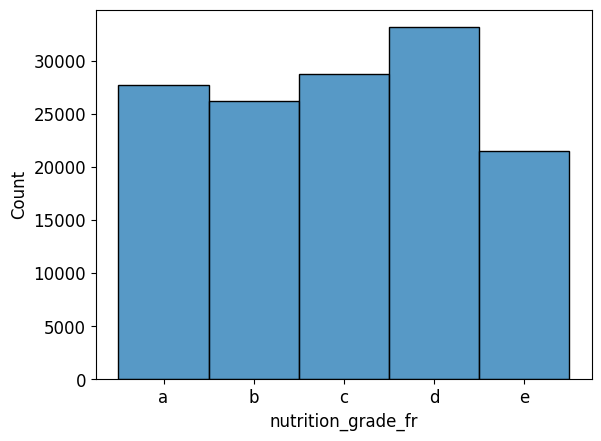

In [21]:
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])
sns.histplot(data=df["nutrition_grade_fr"])

## Étape 3 : Identifiez et traitez les valeurs manquantes

<Axes: xlabel='fat_100g', ylabel='energy_100g'>

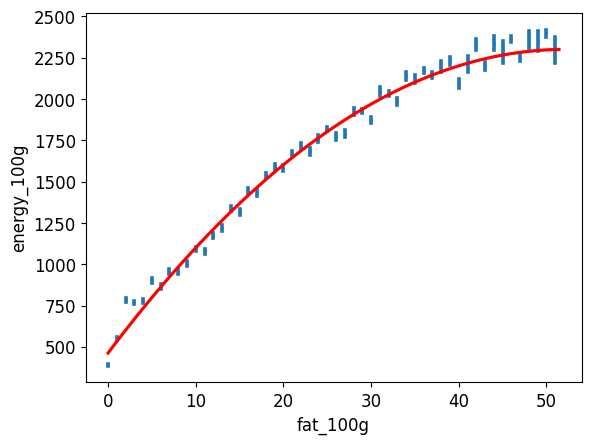

In [22]:
plt.plot(figsize=(20,20))
sns.regplot(data = df, x = "fat_100g", y = "energy_100g", line_kws={"color":"r"}, scatter_kws={"s":1}, x_bins=np.arange(0, 55, 1), order=2)

In [23]:
df[nutritive_values].corr()

,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
energy_100g,1.000000,0.780955,0.491451,0.412113,0.365821,0.205451
fat_100g,0.780955,1.000000,0.287339,0.220560,0.310245,0.249532
sugars_100g,0.491451,0.287339,1.000000,0.115185,-0.171739,-0.215552
fiber_100g,0.412113,0.220560,0.115185,1.000000,0.201845,0.003598
proteins_100g,0.365821,0.310245,-0.171739,0.201845,1.000000,0.311154
salt_100g,0.205451,0.249532,-0.215552,0.003598,0.311154,1.000000


: 

In [24]:
from sklearn import linear_model, neighbors
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
encoded = lab_enc.fit_transform(df["energy_100g"])

X_digits = df[["fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]]
y_digits = encoded
X_digits = X_digits / X_digits.max()

n_samples = len(X_digits)

X_train = X_digits[: int(0.9 * n_samples)]
y_train = y_digits[: int(0.9 * n_samples)]
X_test = X_digits[int(0.9 * n_samples) :]
y_test = y_digits[int(0.9 * n_samples) :]

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression(max_iter=1000)

print(df.head())
print("KNN score: %f" % knn.fit(X_train, y_train).score(X_test, y_test))
print(
    "LogisticRegression score: %f"
    % logistic.fit(X_train, y_train).score(X_test, y_test)
)

            brands                                   ingredients_text  \
1              NaN  Bananas, vegetable oil (coconut oil, corn oil ...   
2   Torn & Glasser  Peanuts, wheat flour, sugar, rice flour, tapio...   
12        Sunridge  Roasted peanuts (peanuts, peanut or canola oil...   
20        Sunridge  Yogurt raisins, tamari roasted almonds, organi...   
21        Sunridge  Chocolate stars (dehydrated cane juice, sweete...   

   nutrition_grade_fr  energy_100g  fat_100g  sugars_100g  fiber_100g  \
1                   d       2243.0     28.57        14.29         3.6   
2                   b       1941.0     17.86        17.86         7.1   
12                  d       2230.0     36.67         3.33         6.7   
20                  d       1464.0     17.50        32.50         5.0   
21                  d       2092.0     33.33        30.00         6.7   

    proteins_100g  salt_100g  
1            3.57    0.00000  
2           17.86    0.63500  
12          16.67    1.60782 